# Updated Project: working with videos

In [1]:
import os
import tarfile

# THE DATA WAS SAVED AS TAR FILES, WE USED THIS BLOCK OF CODE TO EXTRACT

PATH = "this is the path to the ./frames/"

# Take a look at folders
for dirpath, dirnames, filenames in os.walk(PATH):
  print(f"There are {len(dirnames)} directories and {len(filenames)} tar files in '{dirpath}'.",
        "*"*80,
        sep="\n"
        )

  # Extract tar files
  for tar in filenames:
    print(f"Extracting tarfile {tar}...")
    tar_path = PATH + str(tar)
    open_tar = tarfile.open(tar_path)
    open_tar.extractall()
    open_tar.close()
    print(f"Finished extracting tarfile {tar}",
          "*"*80,
          sep="\n"
          )

# Dataset Annotations

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

header= ['video', 'label', 'id', 't_start', 't_end', 'frames']
train_path = "./Annot_TrainList.txt"
test_path = "./Annot_TestList.txt"

train_annot = pd.read_csv(train_path,
                          header=0,
                          names=header)

test_annot = pd.read_csv(test_path,
                          header=0,
                          names=header)

In [2]:
# Labels are from 1-14, change to 0-13 for spare cat/ Dense layer (14)
train_annot['id'] = train_annot['id'] - 1
test_annot['id'] = test_annot['id'] - 1

print(train_annot.id.value_counts(), test_annot.id.value_counts())

0     921
1     745
2     743
6     149
4     148
8     148
10    148
12    148
3     148
5     148
7     148
9     148
11    148
13    148
Name: id, dtype: int64 0     508
1     265
2     264
3      52
4      52
5      52
6      52
7      52
8      52
9      52
10     52
11     52
12     52
13     52
Name: id, dtype: int64


In [3]:
train_balanced = []

for name, group in train_annot.groupby("video"):
    sample = group.sample(20)
    train_balanced.append(sample)
    
train_balanced = pd.concat(train_balanced, ignore_index=False)

train_balanced

,video,label,id,t_start,t_end,frames
16,1CM1_4_R_#229,G10,12,2604,2646,43
18,1CM1_4_R_#229,D0X,0,2795,2993,199
9,1CM1_4_R_#229,G02,4,1433,1457,25
2,1CM1_4_R_#229,G04,6,285,308,24
20,1CM1_4_R_#229,B0A,1,3030,3232,203
...,...,...,...,...,...,...
4016,4CM11_7_R_#36,B0B,2,481,697,217
4028,4CM11_7_R_#36,B0B,2,2279,2486,208
4031,4CM11_7_R_#36,B0B,2,3023,3255,233
4032,4CM11_7_R_#36,G08,10,3256,3332,77


0     15
1     15
2     15
5     15
6     15
7     15
8     15
9     15
10    15
11    15
12    15
4     14
13    14
3     10
Name: id, dtype: int64


,video,label,id,t_start,t_end,frames
2685,4CM11_11_R_#4,D0X,0,399,515,117
2687,4CM11_11_R_#4,D0X,0,641,737,97
1550,1CV12_16_R_#105,D0X,0,1,101,101
2319,1CV12_8_R_#86,D0X,0,147,240,94
1654,1CV12_1_R_#65,D0X,0,1,97,97
...,...,...,...,...,...,...
1505,1CV12_13_R_#95,G11,13,1007,1097,91
3335,4CM11_1_R_#16,G11,13,2935,3063,129
256,1CM42_12_R_#159,G11,13,32,146,115
3998,4CM11_7_R_#35,G11,13,1927,2046,120


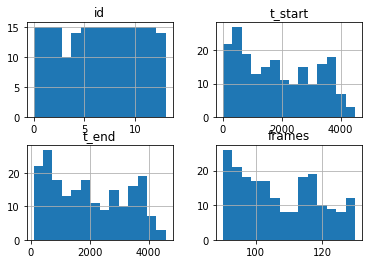

In [4]:
train_annot_final = train_balanced[(train_balanced["frames"] <=130) & (train_balanced["frames"] >= 90)].groupby(
    'id', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 15))
)

train_annot_final = train_annot_final.iloc[:, :]

train_annot_final.hist(bins=14)
print(train_annot_final.id.value_counts())
train_annot_final

###### Creating Test set

0     9
5     9
6     9
7     9
9     9
13    9
10    8
12    8
3     7
8     7
4     6
11    6
1     3
2     1
Name: id, dtype: int64


,video,label,id,t_start,t_end,frames
658,1CM42_31_R_#131,D0X,0,3745,3840,96
197,1CM1_2_R_#223,D0X,0,606,697,92
178,1CM1_2_R_#222,D0X,0,2764,2874,111
141,1CM1_2_R_#221,D0X,0,3406,3495,90
229,1CM1_2_R_#223,D0X,0,3700,3826,127
...,...,...,...,...,...,...
685,1CM42_31_R_#132,G11,13,4039,4139,101
708,1CV12_12_R_#89,G11,13,3373,3463,91
614,1CM42_31_R_#130,G11,13,428,539,112
971,1CV12_21_R_#109,G11,13,1209,1318,110


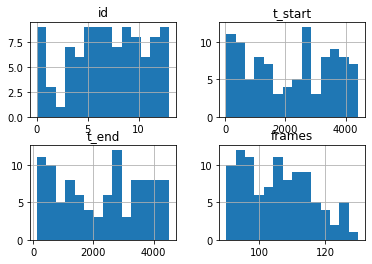

In [7]:
test_annot_final = test_annot[(test_annot["frames"] <= 130) & (test_annot["frames"] >= 90)].groupby(
    'id', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 9))
)

test_annot_final.hist(bins=14)
print(test_annot_final.id.value_counts())
test_annot_final

In [22]:
len(test_annot_final)

64

# Extract Video Frame Tar files

In [8]:
import cv2
import numpy as np
import glob


def img_array_generator(frame_folder):
  """
  Generates image data --> (320, 240, 3) from frame folders.
  NOTE: Each frame folder represents an entire video that is already separated
    into frames
  """
  # Choose which folder to extract data from
  path = 'C:/Users/dm0469/OneDrive - UNT System/Documents/Machine Learning/Hand Gesture Recognition/frames/' + str(frame_folder) + '/*.jpg'
  img_array = []

  # Iterate through all the frames, process, and append to final array
  for filename in sorted(glob.glob(path)): # <-- using sorted since glob.glob unorders files
      img = cv2.imread(filename)
      img = cv2.resize(img, (224, 224)) / 255. # normalize
      img_array.append(img)

  return np.array(img_array)

In [9]:
def retrieve_clips(row, img_array, dataset):

    """
    For each row in dataset:
    1. Use start and end time to capture frame sequence from image array
      and add it to video_clips dataset
    2. Extract label from given row and add it to video_labels dataset
    """
    global i

    start = row['t_start']
    end = row['t_end']
    label = row['id']

    y[f"{dataset}_labels"][i] = label

    # Get sequence of frames
    clip = img_array[start:end]
    length = len(clip)
    
    
    # Set frames to 116
    if length > 116:
        truncated_clip = clip[:116, :, :, :]
        x[f"{dataset}_clips"][i] = truncated_clip

    else:
        extra = 116 - length
        padding = np.zeros((extra , 224, 224, 3))
        padded_clip = np.concatenate([clip, padding], axis=0)
        x[f"{dataset}_clips"][i] = padded_clip

    i += 1
  

## Storing data

In [9]:
train_annot_final = train_annot_final.sort_values("video").reset_index()

train_annot_final



,index,video,label,id,t_start,t_end,frames
0,126,1CM42_11_R_#205,B0B,2,3533,3657,125
1,148,1CM42_11_R_#206,G10,12,3860,3957,98
2,133,1CM42_11_R_#206,G06,8,818,911,94
3,138,1CM42_11_R_#206,G07,9,1801,1898,98
4,223,1CM42_12_R_#157,G11,13,3536,3635,100
...,...,...,...,...,...,...,...
196,3989,4CM11_7_R_#35,G05,7,362,476,115
197,3993,4CM11_7_R_#35,G06,8,1054,1163,110
198,4015,4CM11_7_R_#36,G10,12,386,480,95
199,4021,4CM11_7_R_#36,G01,3,1316,1433,118


## Creating CV HDF5 File

In [14]:
import h5py

k = 0

train_shape = (20, 116, 224, 224, 3)

for count in range(0, 200, 20):
    
    # Create group of 20
    subset = train_annot_final.iloc[count:count + 20, :]
            
    X_TRAIN_HDF5_PATH = f"./hdf5 data/X_train_{k}.hdf5"
    Y_TRAIN_HDF5_PATH = f"./hdf5 data/y_train_{k}.hdf5"
    
    
    # Create h5py object for current subset
    x = h5py.File(X_TRAIN_HDF5_PATH, mode='w')
    y = h5py.File(Y_TRAIN_HDF5_PATH, mode='w')
    
    # Create test_dataset
    x.create_dataset(f"train_clips", train_shape, np.float32)
    
    # dictionary form
    y.create_dataset(f"train_labels", (20,), np.float32)
    
    # Iterate through the subset
    i = 0
    
    for name, group in subset.groupby("video"):
        
        current_img_array = img_array_generator(name)

        print("*"*80)
        print("NAME:", name)
        print("-"*80)
        group.apply(lambda row: retrieve_clips(row, current_img_array, "train"),
                    axis=1
                    )

    print(f"Finished creating HDF5 file {k}")
    
    k += 1    
        
    # Close current hdf5 file
    x.close()
    y.close()
        

********************************************************************************
NAME: 1CM1_2_R_#221
--------------------------------------------------------------------------------
********************************************************************************
NAME: 1CM1_2_R_#222
--------------------------------------------------------------------------------
********************************************************************************
NAME: 1CM1_2_R_#223
--------------------------------------------------------------------------------
********************************************************************************
NAME: 1CM42_30_R_#146
--------------------------------------------------------------------------------
********************************************************************************
NAME: 1CM42_31_R_#129
--------------------------------------------------------------------------------
********************************************************************************
NAME:

## Creating Test HDF5 file

In [15]:
test_annot_final = test_annot_final.sort_values("video").reset_index()

test_annot_final


,index,video,label,id,t_start,t_end,frames
0,141,1CM1_2_R_#221,D0X,0,3406,3495,90
1,134,1CM1_2_R_#221,B0A,1,2730,2833,104
2,178,1CM1_2_R_#222,D0X,0,2764,2874,111
3,197,1CM1_2_R_#223,D0X,0,606,697,92
4,229,1CM1_2_R_#223,D0X,0,3700,3826,127
...,...,...,...,...,...,...,...
95,1348,4CM11_20_R_#41,G01,3,1471,1583,113
96,1365,4CM11_20_R_#42,G11,13,30,147,118
97,1380,4CM11_20_R_#42,G06,8,2520,2628,109
98,1417,4CM11_20_R_#44,G05,7,51,161,111


In [16]:
import h5py

k = 0

test_shape = (20, 116, 224, 224, 3)

for count in range(0, 100, 20):
    
    # Create group of 20
    subset = test_annot_final.iloc[count:count + 20, :]
            
    X_TEST_HDF5_PATH = f"./hdf5 data/test/X_test_{k}.hdf5"
    Y_TEST_HDF5_PATH = f"./hdf5 data/test/y_test_{k}.hdf5"
    
    
    # Create h5py object for current subset
    x = h5py.File(X_TEST_HDF5_PATH, mode='w')
    y = h5py.File(Y_TEST_HDF5_PATH, mode='w')
    
    # Create test_dataset
    x.create_dataset(f"test_clips", test_shape, np.float32)
    
    # dictionary form
    y.create_dataset(f"test_labels", (20,), np.float32)
    
    # Iterate through the subset
    i = 0
    
    for name, group in subset.groupby("video"):
        
        current_img_array = img_array_generator(name)

        print("*"*80)
        print("NAME:", name)
        print("-"*80)
        group.apply(lambda row: retrieve_clips(row, current_img_array, "test"),
                    axis=1
                    )

    print(f"Finished creating HDF5 test file {k}")
    
    k += 1    
        
    # Close current hdf5 file
    x.close()
    y.close()

********************************************************************************
NAME: 1CM1_2_R_#221
--------------------------------------------------------------------------------
********************************************************************************
NAME: 1CM1_2_R_#222
--------------------------------------------------------------------------------
********************************************************************************
NAME: 1CM1_2_R_#223
--------------------------------------------------------------------------------
********************************************************************************
NAME: 1CM42_30_R_#146
--------------------------------------------------------------------------------
********************************************************************************
NAME: 1CM42_31_R_#129
--------------------------------------------------------------------------------
********************************************************************************
NAME:

Label: Zoom out
60


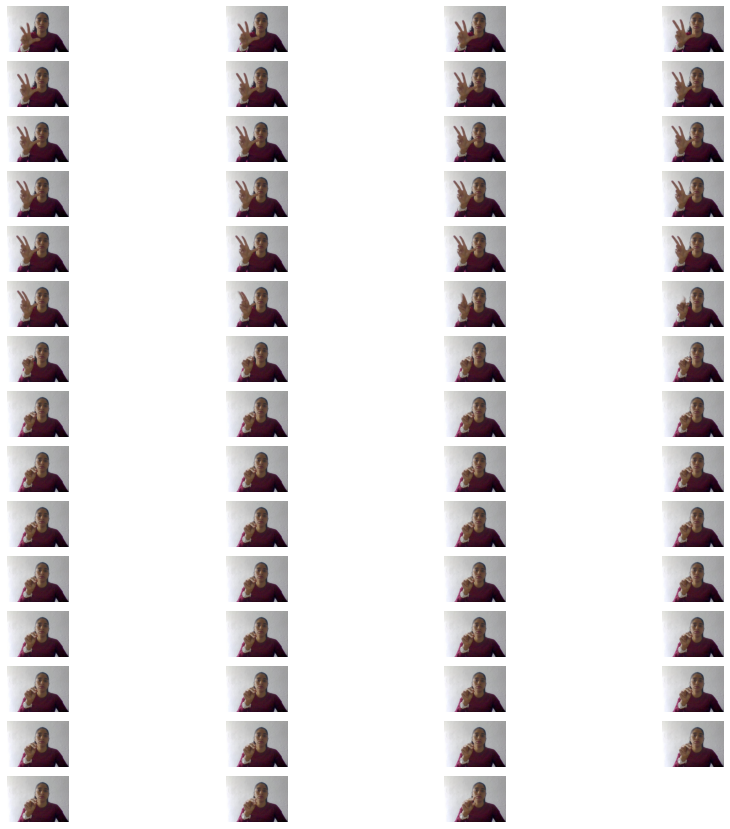

In [ ]:
import matplotlib.pyplot as plt


labels_dict = {1:"Non-gesture",
               2:"Pointing with one finger",
               3:"Pointing with two fingers",
               4:"Click with one finger",
               5:"Click with two fingers",
               6:"Throw up",
               7:"Throw down",
               8:"Throw left",
               9:"Throw right",
               10:"Open twice",
               11:"Double click with one finger",
               12:"Double click with two fingers",
               13:"Zoom in",
               14:"Zoom out"
}

sample = 4

w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 15

print(f"Label: {labels_dict[video_labels[sample]]}")
print(len(video_clips[sample]))
for i in range(1, columns*rows ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(video_clips[sample][i], cv2.COLOR_BGR2RGB))
    plt.axis('off')


plt.show()

<hr>

# IGNORE EVERYTHING BELOW THIS
## THIS WAS OUR PREVIOUS PROJECT USING STATIC HAND GESTURE RECOGNITION


# Previous Image Classification Task

In [ ]:
!pip install split-folders

In [ ]:
import zipfile
import os
import splitfolders

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/AI Wearables/Project 1/archive.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Take a look at folders
for dirpath, dirnames, filenames in os.walk("HandGesture/images/"):
  if len(dirnames) == 10:
    continue

  else:
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 537 images in 'HandGesture/images/thumbs'.
There are 0 directories and 539 images in 'HandGesture/images/paper'.
There are 0 directories and 527 images in 'HandGesture/images/scissor'.
There are 0 directories and 527 images in 'HandGesture/images/call_me'.
There are 0 directories and 540 images in 'HandGesture/images/okay'.
There are 0 directories and 508 images in 'HandGesture/images/rock'.
There are 0 directories and 504 images in 'HandGesture/images/up'.
There are 0 directories and 531 images in 'HandGesture/images/rock_on'.
There are 0 directories and 504 images in 'HandGesture/images/fingers_crossed'.
There are 0 directories and 526 images in 'HandGesture/images/peace'.


In [ ]:
# Create train, val and test folders
input = "/content/HandGesture/images"

splitfolders.ratio(input, output=input)    

Copying files: 5243 files [00:01, 4389.87 files/s]


In [ ]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir + "/" + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img, cmap='gray')
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

Image shape: (195, 240)


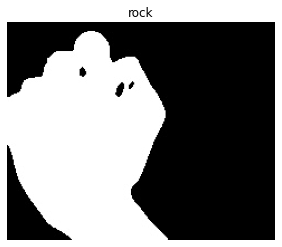

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir=input,
                        target_class="rock")

In [ ]:
import tensorflow as tf

tf.constant(img)

<tf.Tensor: shape=(195, 240), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (normalize, augment data)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.3,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.3,
                                   horizontal_flip=True)

# Setup paths to our data directories
train_dir = "/content/HandGesture/images/train"
valid_dir = "/content/HandGesture/images/val"

In [ ]:
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=valid_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 4190 images belonging to 10 classes.
Found 519 images belonging to 10 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False) # top layer is the output layer, we change depending on number of outputs
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = layers.Conv2D(3, (3, 3), padding='same')(inputs)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen will
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x) # since its a layer, we need to pass a layer (the others above are whole models)
outputs = layers.Dense(10, activation="softmax", name="output_later")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Get summary of model we've created
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 3)       30        
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_avg_pool_layer (Globa (None, 2048)              0         
_________________________________________________________________
output_later (Dense)         (None, 10)                20490     
Total params: 23,608,232
Trainable params: 20,520
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fit the model
history_0 = model.fit(train_data,
                      epochs=5,
                      validation_data=valid_data)

Epoch 1/5
131/131 [==============================] - 88s 640ms/step - loss: 2.0818 - accuracy: 0.2446 - val_loss: 1.4439 - val_accuracy: 0.4817
Epoch 2/5
131/131 [==============================] - 83s 632ms/step - loss: 1.0026 - accuracy: 0.6909 - val_loss: 0.7446 - val_accuracy: 0.7611
Epoch 3/5
131/131 [==============================] - 83s 629ms/step - loss: 0.5076 - accuracy: 0.8475 - val_loss: 0.4587 - val_accuracy: 0.8632
Epoch 4/5
131/131 [==============================] - 82s 624ms/step - loss: 0.3520 - accuracy: 0.9002 - val_loss: 0.3640 - val_accuracy: 0.8921
Epoch 5/5
131/131 [==============================] - 82s 624ms/step - loss: 0.2848 - accuracy: 0.9146 - val_loss: 0.2788 - val_accuracy: 0.9075


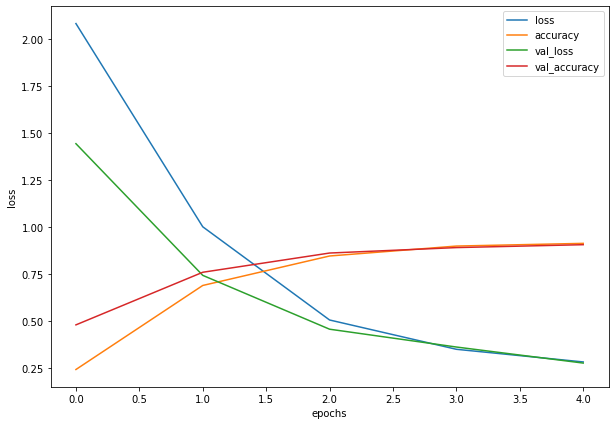

In [ ]:
import pandas as pd

pd.DataFrame(data=history_0.history).plot(figsize=(10,7))
plt.ylabel("loss")
plt.xlabel("epochs");